In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
for table_name, table in Base.classes.items():
    print("Table Name:", table_name)
    print("Columns:")
    for column in table.__table__.columns:
        print(column.name)

Table Name: measurement
Columns:
id
station
date
prcp
tobs
Table Name: station
Columns:
id
station
name
latitude
longitude
elevation


In [6]:
# View all of the classes that automap found
table_names = Base.classes.keys()
table_names

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

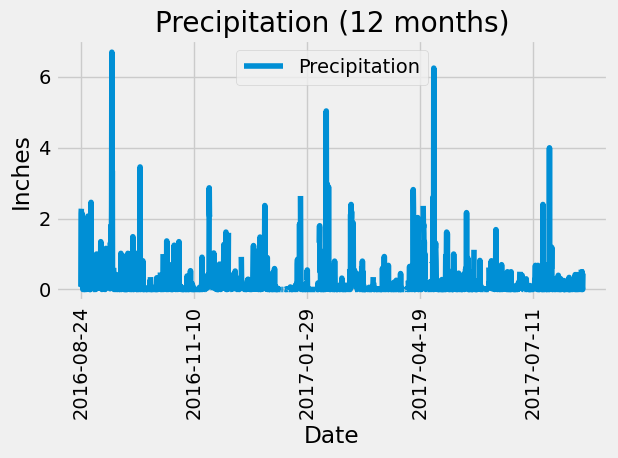

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
last_year = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.sort_values(by='Date',ascending=True)
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot last 12 months, make x labels rotate 90 degrees, and make sure to have 9 x ticks
precipitation_df.plot(title="Precipitation (12 months)")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Images/Precipitation.png")
plt.show()




In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
print(f"Total Stations: {total_stations}")


Total Stations: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())
for station in active_stations:
    print(station)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
most_active_station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Most Active Station: {most_active_station}")


Most Active Station: USC00519281


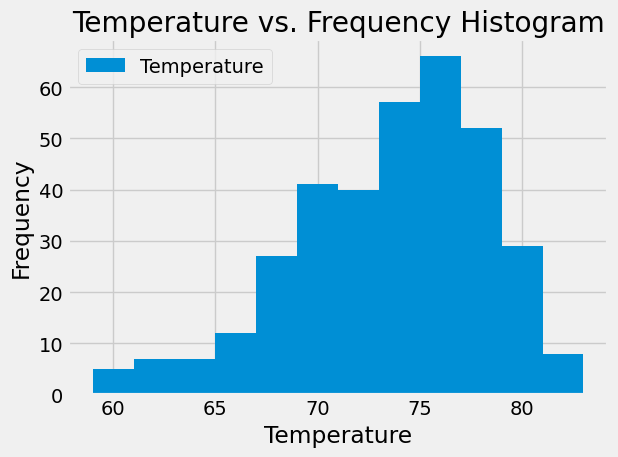

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_year = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= last_year).all()
most_active_station_year_df = pd.DataFrame(most_active_station_year, columns=['Temperature'])
most_active_station_year_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.xlabel("Temperature")
plt.tight_layout()
plt.savefig("Images/Temperature vs Frequency.png")
plt.show()


# Close Session

In [22]:
# Close Session
session.close()